# Introdução

## Dissecting GitHub Code Reviews: A Text Classification Experiment


Esse script é baseado no trabalho de Muntazir Fadhel, disponível em:

http://mfadhel.com/github-code-reviews/

# Objetivos 

Reproduzir o experimento de Fadhel, utilizando como entrada comentários de Pull Requests do projeto [Flutter](https://github.com/flutter/flutter).

# To-Do

**09/10/2020**

> (X) Fazer o download dos dados do projeto Flutter;

> (X) Classificar manualmente os comentários de PR;

> (X) Reproduzir o experimento;

> (X) Começar a estudar os algoritmos de classificação;

> (X) Atualizar o arquivo Meeting Minutes.

**22/10/2020**

> (X) Verificar como métricas de precision e recall estão sendo calculadas

> ( ) Ler artigos enviados (além de insights sobre categorias, fornece insights sobre possíveis features)

> (X) Compartilhar notebook

> (X) Expandir o development set

## Input dos dados

Estão disponíveis em [input](./input/)

* Foram coletados comentários de revisão de 2586 Pull Requests do projeto Flutter;
* Destes, apenas 1792 pussuíam pelo menos 1 comentário;
* No total foram coletados **6261** comentários.


<p>&nbsp;</p>

A estrutura dos arquivos de input é:

[flutter_review_comments.txt](./input/flutter_review_comments.txt): arquivo contendo todos os comentários mencionados.

[flutter_development_set_review_comments.txt](./input/flutter_development_set_review_comments.txt): arquivo contendo um subconjunto de **200** comentários randomicamente selecionados, que serão utilizados neste experimento.

[flutter_development_set_review_comments_labels.txt](./input/flutter_development_set_review_comments_labels.txt): arquivo contendo os labels associados ao subconjunto mencionado.

<p>&nbsp;</p>

As categorias definidas por Fadhel são as seguintes:

| Category| Label | Further Explanation|  &nbsp; &nbsp; &nbsp;Sample Comment &nbsp; &nbsp; &nbsp;    |    
|-------------------|-------|--------------|-------------------------------------------------------|
| Readability                     | 1     | Comments related to readability, style, general project conventions.                                | "Please split this statement into two separate ones" |
| Naming                          | 2     |                                                                                                     | "I think foo would be a more appropriate name" |
| Documentation                   | 3     | Comments related to licenses, package info, module documentation, commenting.                       |"Please add a comment here explaining this logic" |
| Error/Resource Handling         | 4     | Comments related to exception/resource handling, program failure,  termination analysis, resource . |"Forgot to catch a possible exception here" |
| Control Structures/Program Flow | 5     | Comments related to usage of loops, if-statements, placement of individual lines of code.           |"This if-statement should be moved after the while loop" |
| Visibility/ Access              | 6     | Comments related to access level for classes, fields, methods and local variables.                  |"Make this final" |
| Efficiency / Optimization       | 7     |                                                                                                     |"Many uneccessary calls to foo() here" |
| Code Organization/ Refactoring  | 8     | Comments related to extracting code from methods and classes, moving large chunks of code around.   |"Please extract this logic into a separate method" |
| Concurrency                     | 9    | Comments related to threads, synchronization, parallelism.                                          |"This class does not look thread safe" |
| High Level Method Semantics & Design                           | 10    | Comments relating to method design and semantics.                                                           |"This method should return a String" |
| High Level Class Semantics & Design                           | 11    | Comments relating to class design and semantics.                                                           |"This should extend Foo" |
| Testing                           | 12    |                                                           |"is there a test for this?" |
| Other                           | 13    | Comments not relating to categories 1-12.                                                           |"Looks good", "done", "thanks" |

In [1]:
with open('input/flutter_development_set_review_comments.txt') as f:
    review_comments = f.readlines()
    
with open('input/flutter_development_set_review_comments_labels.txt') as g:
    classifications = g.readlines()

## Pré-processamento dos dados

O trecho de código a seguir é uma implementação sugerida por Fadhel de pré-processamento dos dados. Segundo ele, a remoção de stopwords e "stemmizadores" resultam numa queda da acurácia do classificador final.

In [2]:
import re 

def formatComment(comment):
        comment = re.sub("\*|\[|\]|#|\!|,|\.|\"|;|\?|\(|\)|`.*?`", "", comment)
        comment = re.sub("\.|\(|\)|<|>", " ", comment)
        comment = ' '.join(comment.split())
        return comment
        

def formatComments(comments):
    for index, comment in enumerate(comments):
        comments[index] = formatComment(comment)  

formatComments(review_comments)

## Extração de Features
* Ele utiliza o modelo _bag of words_ e faz a vetorização das palavras dos comentários

In [3]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word')
comments_train_counts = count_vect.fit_transform(review_comments)
comments_train_counts.shape

(305, 1526)

* Após a vetorização dos comentários de revisão, o autor utiliza TF-IDF para atribuir um peso à cada palavra presente no conjunto.

In [4]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
comments_train_tfidf = tfidf_transformer.fit_transform(comments_train_counts)
comments_train_tfidf.shape

(305, 1526)

## Divisão dos dados em treino/teste

In [61]:
from sklearn.model_selection import train_test_split

comment_train, comment_test, classification_train, classification_test = train_test_split(review_comments, classifications, test_size=0.25)

## Treino de um SVM
O autor utiliza Stochastic Gradient Descent (SGD) para realizar o treinamento de um SVM.

"In multilabel confusion matrix `MCM`, the count of true negatives is `MCM{0,0}`, false negatives is :math:`MCM{1,0}`, true positives is `MCM{1,1}` and false positives is `MCM{0,1}`.

Multiclass data will be treated as if **binarized under a one-vs-rest transformation**. Returned confusion matrices will be in the order of sorted unique labels in the union of (y_true, y_pred). 

The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The **support** is the number of occurrences of each class in y_true.
"


In [83]:
# Training Support Vector Machines - SVM and calculating its performance
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), 
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='elasticnet',alpha=1e-3, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(review_comments, classifications)
predicted_svm = text_clf_svm.predict(comment_test)

print(classification_report(classification_test, predicted_svm))
print(multilabel_confusion_matrix(classification_test, predicted_svm))

              precision    recall  f1-score   support

          1
       1.00      1.00      1.00         4
         10
       1.00      1.00      1.00         6
         11
       1.00      1.00      1.00         4
         12
       1.00      1.00      1.00         5
         13
       0.87      1.00      0.93        13
          2
       1.00      1.00      1.00         8
          3
       1.00      1.00      1.00         5
          4
       1.00      1.00      1.00         3
          5
       1.00      0.80      0.89         5
          6
       1.00      1.00      1.00         5
          7
       1.00      1.00      1.00         5
          8
       1.00      0.86      0.92         7
          9
       1.00      1.00      1.00         7

    accuracy                           0.97        77
   macro avg       0.99      0.97      0.98        77
weighted avg       0.98      0.97      0.97        77

[[[73  0]
  [ 0  4]]

 [[71  0]
  [ 0  6]]

 [[73  0]
  [ 0  4]]

 [[72  0]
  [

## Problema!

O autor considerou que o f1-score obtido (81%) não era confiável o suficiente. Ele obteve melhores resultados não utilizando TF-IDF, dado o fato de o algoritmo estar priorizando termos erroneamente.

In [84]:
# Training Support Vector Machines - SVM and calculating its performance
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), 
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='elasticnet',alpha=1e-3, max_iter=10000, random_state=42))])

text_clf_svm = text_clf_svm.fit(review_comments, classifications)
predicted_svm = text_clf_svm.predict(comment_test)
print(classification_report(classification_test, predicted_svm))
print(multilabel_confusion_matrix(classification_test, predicted_svm))

              precision    recall  f1-score   support

          1
       1.00      1.00      1.00         4
         10
       1.00      1.00      1.00         6
         11
       1.00      1.00      1.00         4
         12
       1.00      1.00      1.00         5
         13
       1.00      1.00      1.00        13
          2
       1.00      1.00      1.00         8
          3
       1.00      1.00      1.00         5
          4
       1.00      1.00      1.00         3
          5
       0.83      1.00      0.91         5
          6
       1.00      1.00      1.00         5
          7
       1.00      1.00      1.00         5
          8
       1.00      0.86      0.92         7
          9
       1.00      1.00      1.00         7

    accuracy                           0.99        77
   macro avg       0.99      0.99      0.99        77
weighted avg       0.99      0.99      0.99        77

[[[73  0]
  [ 0  4]]

 [[71  0]
  [ 0  6]]

 [[73  0]
  [ 0  4]]

 [[72  0]
  [

## Plot
Aqui cada um dos comentários de revisão é classificado utilizando o SVM treinado. E essa classificação é plotada em um `donut chart`.

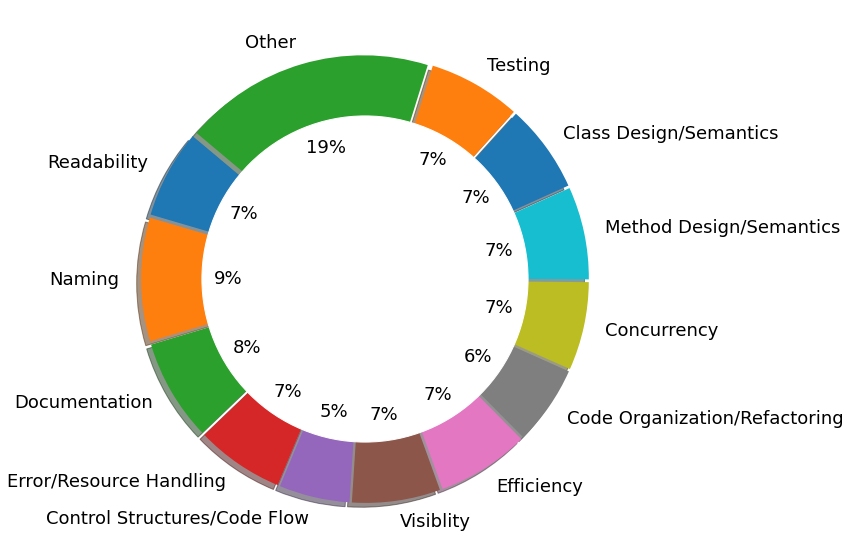

In [35]:
import matplotlib.pyplot as plt
import matplotlib
from palettable.tableau import Tableau_10

matplotlib.rcParams.update({'font.size': 18})

# Data to plot
labels = ['Readability', 'Naming', 'Documentation', 'Error/Resource Handling', 
'Control Structures/Code Flow', 'Visiblity', 'Efficiency', 'Code Organization/Refactoring',
'Concurrency', 'Method Design/Semantics', 'Class Design/Semantics', 'Testing', 'Other']


sizes = [0] * 13
explode = [0.03] * 13

# loop through review comments and score
for review_comment in review_comments:
    label = int(text_clf_svm.predict([formatComment(review_comment)])[0])
    sizes[label - 1] += 1

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.75, color='white')

# Plot
plt.pie(sizes, labels=labels, colors=Tableau_10.hex_colors,
        autopct='%1.0f%%', explode=explode, shadow=True, startangle=140) 
fig = plt.gcf().set_size_inches(10,10) 
plt.gca().add_artist(my_circle)
plt.show()